# Installation

In [2]:
!git clone https://github.com/TheShenk/hai-nonconflict-action-learning.git

Cloning into 'hai-nonconflict-action-learning'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 83 (delta 25), reused 43 (delta 17), pack-reused 30
Unpacking objects: 100% (83/83), done.


In [1]:
%cd hai-nonconflict-action-learning/

/content/hai-nonconflict-action-learning


In [2]:
!pip install stable-baselines3[extra] pymunk pygame sb3-contrib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [1]:
import gym
import gym_futbol
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback

import utils
from multiagent import MultiAgentOnPolicyProxy, multiagent_learn, MultiAgentOffPolicyProxy
from IPython import display

pygame 2.1.0 (SDL 2.0.16, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Basics

Reset


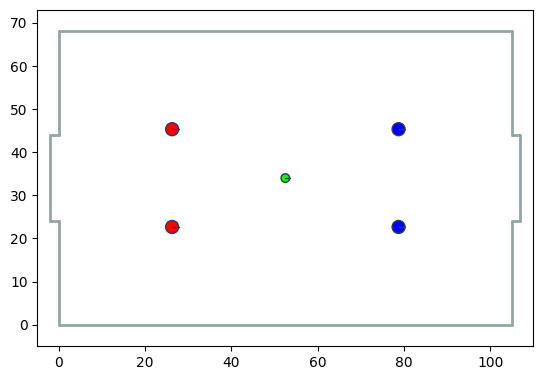

In [2]:
env = gym.make("Futbol2v2-v1")
env.render()

In [5]:
env.action_space

MultiDiscrete([5 5 5 5])

In [6]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

# Learning model

In [2]:
log_dir = "logs/"
timesteps = 50000

In [3]:
from stable_baselines3.common.env_util import make_vec_env

env = gym.make("Futbol2v2-v1")
env = make_vec_env(lambda: env, n_envs=4, monitor_dir=log_dir)
model = PPO("MlpPolicy", env, device='cpu')
model.learn(timesteps)
model.save("models/footbol2v2-ppo")

# Display model statistic

     index            r   l          t
0        0   155.344302  75   0.836995
1        1    37.251805  75   1.236683
2        2   246.193750  75   1.547551
3        3 -1014.314991  75   1.856825
4        4   295.685775  75   2.164369
..     ...          ...  ..        ...
161    161  1597.695812  75  57.009118
162    162   -56.477502  75  57.346870
163    163  2567.793982  75  57.695286
164    164   363.661477  75  58.012881
165    165   113.101150  75  58.335833

[166 rows x 4 columns]


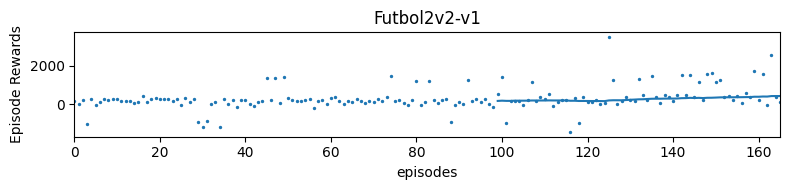

In [4]:
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Futbol2v2-v1")
display.display(plt.gcf())
display.clear_output(wait=True)

log_data = results_plotter.load_results(log_dir)
print(log_data)

# Load model from file

In [12]:
model = PPO.load("models/footbol2v2-ppo", device="cpu")

# Run models

## Pygame
Run game with model in new windows with pygame

In [13]:
RES = WIDTH, HEIGHT = 600, 400
FPS = 60

env = gym.make("Futbol2v2-v1")
visualizer = utils.PygameVisualizer(env, RES, FPS)
visualizer.run(model)

env.close()
visualizer.close()

## Matplotlib
Run model in notebook with matplotlib

KeyboardInterrupt: 

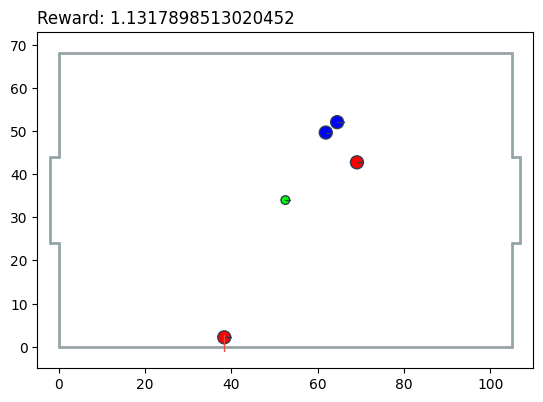

In [25]:
env = gym.make("Futbol2v2-v1")

visualizer = utils.MatplotlibVisualizer(env)
visualizer.run(model)

env.close()

# MultiAgent

## Learn

In [5]:
log_dir = "logs/futbol/ppo"
env = make_vec_env(lambda: gym.make("Futbol2v2-v1", action_space_type="box"), n_envs=1, monitor_dir=log_dir)

models = [
    MultiAgentOnPolicyProxy(PPO("MlpPolicy",
                             utils.TransformAction(env, gym.spaces.Box(low=-1.0, high=1.0, shape=(1, 4))),
                             device='cpu')),
    MultiAgentOnPolicyProxy(PPO("MlpPolicy",
                             utils.TransformAction(env, gym.spaces.Box(low=-1.0, high=1.0, shape=(1, 4))),
                             device='cpu'))
]

timesteps = 50000

### Rewrote learning cycle
StableBaselines3 не поддерживает одновременное обучение нескольких агентов, это даже не ошибка по мнению разработчиков. Они считают, что в данном случае каждому пользователю необходимо самостоятельо переопределить цикл обучения (для не мультиагентных задач используется метод learn). Здесь представлен код, взятый из исходных кодов StableBaselines3, но адаптированный для многоагентных задач.
В обычной ситуации, learn сам взаимодействует со средой. Но при существовании нескольких агентов нужно получить действие от каждого и только потом передавать их в среду. Именно это здесь и реализовано. Каждому агенту передается наблюдение от среды (в данной задаче оно одинаково для всех) и получается действие. Затем действия объеядиняются и передаются среде. Затем каждый агент обновляется с учетом полученных данных (метод record).
Весь код, взятый из StableBaselines3 вынесен в класс MultiAgentModelProxy.

In [6]:
#TODO: Изучение падения результатов при переходе от централизованного к конкурентному подходу - кандидат на критерий неконфликтности обучения
#TODO: Изучить изменения результатов конкурентного подхода при добавлении общения (еще один параметр в пространстве наблюдений, интерпритировать как цвет, его значение на следующем шаге - новый элемент пространства действий)
#TODO: Изучить способность к обучению сразу нескольким ролям. Для этого после каждого эпизода обучения случайным образом менять агента напарника на SimpleAttackAgent или SimpleGoalkeeperAgent
#TODO: Рассмотреть возможность асинхронной среды. Для нее не требуется объединять действия.

In [7]:
multiagent_learn(models, timesteps, env, "models/footbol/ppo")

/tmp/ipykernel_6364/566115823.py:1: DeprecationWarning: Parameters `eval_env` and `eval_freq` are deprecated and will be removed in the future. Please use `EvalCallback` or a custom Callback instead.
  multiagent_learn(models, timesteps, env, "models/footbol/ppo")


2048 [3326.1494]
4096 [2343.977]
6144 [6089.742]
8192 [3482.7146]
10240 [4693.9946]
12288 [2733.1423]
14336 [6659.071]
16384 [6916.577]
18432 [7119.138]
20480 [3413.466]
22528 [7390.3765]
24576 [3820.3098]
26624 [4656.6743]
28672 [7303.35]
30720 [5957.359]
32768 [6850.183]
34816 [5931.638]
36864 [2588.1387]
38912 [3754.411]
40960 [5280.109]
43008 [5509.2446]
45056 [5123.45]
47104 [6511.9985]
49152 [42.87065]
51200 [7209.228]


## Statistic

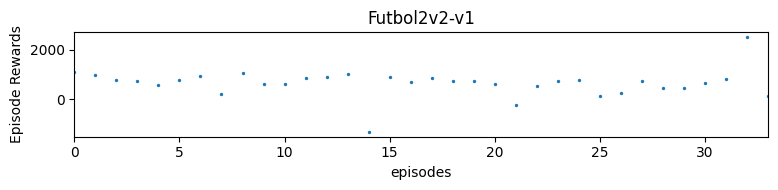

In [5]:
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Futbol2v2-v1")
display.display(plt.gcf())
display.clear_output(wait=True)

## Load and visualise

In [23]:
from stable_baselines3 import PPO

models = [PPO.load(f"models/footbol/ppo-best-{index}", device="cpu") for index in range(2)]

KeyboardInterrupt: 

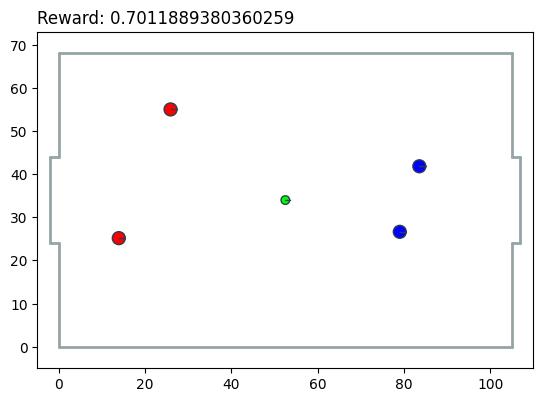

In [4]:
env = gym.make("Futbol2v2-v1", action_space_type="box")

multi_agent = utils.MultiModelAgent(models)

visualizer = utils.MatplotlibVisualizer(env)
visualizer.run(multi_agent)

env.close()

In [26]:
RES = WIDTH, HEIGHT = 600, 400
FPS = 60

env = gym.make("Futbol2v2-v1", action_space_type="discrete")
multi_agent = utils.MultiModelAgent(models)

visualizer = utils.PygameVisualizer(env, RES, FPS)
visualizer.run(multi_agent)

env.close()
visualizer.close()

ValueError: zero-dimensional arrays cannot be concatenated

# Algorithms comparison

In [2]:
timesteps = 1000000

## PPO (Centralized & Box)

In [6]:
ALGORITHM_NAME="ppo-centralized-box"
log_dir = f"logs/futbol/{ALGORITHM_NAME}"
env = make_vec_env(lambda: gym.make("Futbol2v2-v1",
                                    action_space_type="box"), n_envs=4, monitor_dir=log_dir)
model = PPO("MlpPolicy", env, verbose=1, device="cpu")

Using cpu device


In [ ]:
model.learn(timesteps)

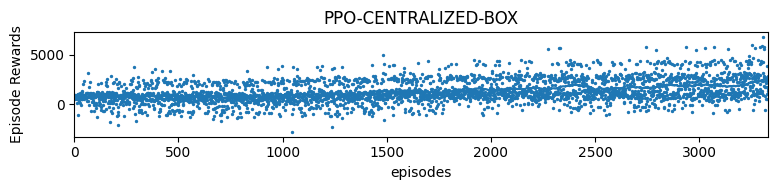

In [7]:
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## PPO (Centralized & Multi-Discrete)

In [8]:
ALGORITHM_NAME="ppo-centralized-multi-discrete"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
env = make_vec_env(lambda: gym.make("Futbol2v2-v1",
                                    action_space_type="multi-discrete"), n_envs=4, monitor_dir=log_dir)
model = PPO("MlpPolicy", env, verbose=1, device="cpu")

Using cpu device


In [ ]:
model.learn(timesteps)

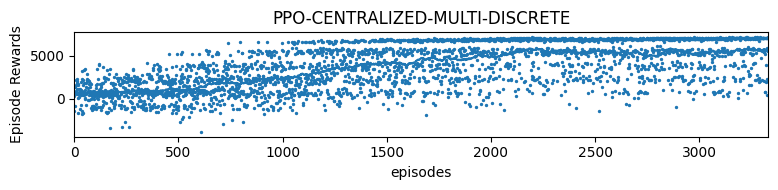

In [9]:
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## PPO (Concurrent & Box)

In [39]:
log_dir = "logs/futbol/ppo"
env = make_vec_env(lambda: gym.make("Futbol2v2-v1",
                                    action_space_type="box"), n_envs=4, monitor_dir=log_dir)

env_iter = iter(env.envs)
ma_action_env = make_vec_env(
    lambda: utils.TransformAction(next(env_iter), gym.spaces.Box(low=-1.0, high=1.0, shape=(1, 4))),
    n_envs=4
)

models = [
    MultiAgentOnPolicyProxy(PPO("MlpPolicy",
                             ma_action_env,
                             device='cpu')),
    MultiAgentOnPolicyProxy(PPO("MlpPolicy",
                             ma_action_env,
                             device='cpu'))
]

In [ ]:
multiagent_learn(models, timesteps, env, "models/footbol/ppo")

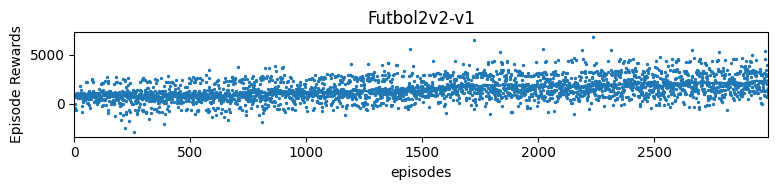

In [41]:
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Futbol2v2-v1")
display.display(plt.gcf())
display.clear_output(wait=True)

## PPO (Concurrent & Multi-Discrete)
Отличительной особенностью PPO является поддержка пространств действий разного вида.
Здесь при использовании Box политика возвращает (направление движения по X, направление движения по Y, направление удара по мячу по X, направление удара по мячу по Y). При этом направление удара имеет смысл только тогда, когда игрок касается мяча.
При использовании Multi-Discrete: Два числа. Первое - направление (0 - стоять на месте, 1,2,3,4 - право, лево, ...). Второе число - действие (0 и 1 - движение вперед по указанному направлению, 2 - удар в направление ворот, 3 - движение по направлению к мячу, 4 - пасс другому игроку)
При использовании Discrete: число от 0 до 24, которое преобразуется в Multi-Discrete как (x//25, x%5)

In [16]:
ALGORITHM_NAME="ppo-multi-discrete"
log_dir = f"logs/futbol/{ALGORITHM_NAME}"

env = make_vec_env(lambda: gym.make("Futbol2v2-v1",
                                    action_space_type="multi-discrete"), n_envs=4, monitor_dir=log_dir)

env_iter = iter(env.envs)
ma_action_env = make_vec_env(
    lambda: utils.TransformAction(next(env_iter), gym.spaces.MultiDiscrete([5, 5])),
    n_envs=4
)

models = [
    MultiAgentOnPolicyProxy(PPO("MlpPolicy",
                             ma_action_env,
                             device='cpu')),
    MultiAgentOnPolicyProxy(PPO("MlpPolicy",
                             ma_action_env,
                             device='cpu'))
]

In [ ]:
multiagent_learn(models, timesteps, env, f"models/footbol/{ALGORITHM_NAME}",
                 action_combiner=utils.MULTI_DISCRETE_COMBINER)

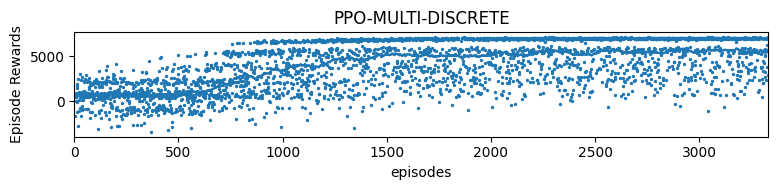

In [18]:
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## PPO (Concurrent & Discrete)

In [23]:
ALGORITHM_NAME="ppo-discrete"
log_dir = f"logs/futbol/{ALGORITHM_NAME}"

env = make_vec_env(lambda: gym.make("Futbol2v2-v1",
                                    action_space_type="discrete"), n_envs=4, monitor_dir=log_dir)

env_iter = iter(env.envs)
ma_action_env = make_vec_env(
    lambda: utils.TransformAction(next(env_iter), gym.spaces.Discrete(25)),
    n_envs=4
)

models = [
    MultiAgentOnPolicyProxy(PPO("MlpPolicy",
                             ma_action_env,
                             device='cpu')),
    MultiAgentOnPolicyProxy(PPO("MlpPolicy",
                             ma_action_env,
                             device='cpu'))
]

In [ ]:
multiagent_learn(models, timesteps, env, f"models/footbol/{ALGORITHM_NAME}",
                 action_combiner=utils.DISCRETE_COMBINER)

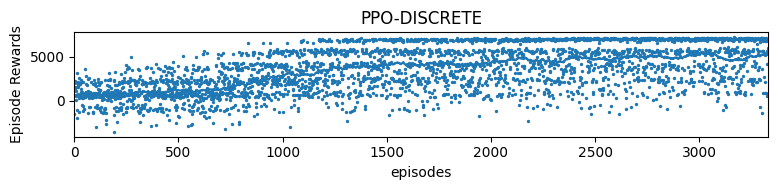

In [25]:
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## TD3

In [2]:
from stable_baselines3 import TD3

log_dir = "logs/futbol/td3"
env = make_vec_env(lambda: gym.make("Futbol2v2-v1", action_space_type="box"), n_envs=4, monitor_dir=log_dir)

env_iter = iter(env.envs)
ma_action_env = make_vec_env(
    lambda: utils.TransformAction(next(env_iter), gym.spaces.Box(low=-1.0, high=1.0, shape=(1, 4))),
    n_envs=4
)

models = [
    MultiAgentOffPolicyProxy(TD3("MlpPolicy",
                             ma_action_env,
                             device='cpu', train_freq=(300, "step"))),
    MultiAgentOffPolicyProxy(TD3("MlpPolicy",
                             ma_action_env,
                             device='cpu', train_freq=(300, "step")))
]

In [ ]:
multiagent_learn(models, timesteps, env, "models/footbol/td3")

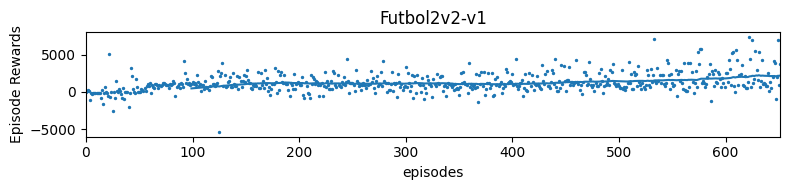

In [56]:
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Futbol2v2-v1")
display.display(plt.gcf())
display.clear_output(wait=True)

## A2C

In [7]:
from stable_baselines3 import A2C
ALGORITHM_NAME="a2c"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
env = make_vec_env(lambda: gym.make("Futbol2v2-v1", action_space_type="box"), n_envs=4, monitor_dir=log_dir)

env_iter = iter(env.envs)
ma_action_env = make_vec_env(
    lambda: utils.TransformAction(next(env_iter), gym.spaces.Box(low=-1.0, high=1.0, shape=(1, 4))),
    n_envs=4
)

models = [
    MultiAgentOnPolicyProxy(A2C("MlpPolicy",
                             ma_action_env,
                             device='cpu')),
    MultiAgentOnPolicyProxy(A2C("MlpPolicy",
                             ma_action_env,
                             device='cpu'))
]

In [ ]:
multiagent_learn(models, timesteps, env, f"models/footbol/{ALGORITHM_NAME}")

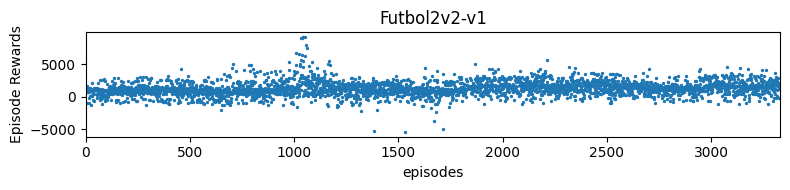

In [9]:
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Futbol2v2-v1")
display.display(plt.gcf())
display.clear_output(wait=True)

## SAC

In [10]:
from stable_baselines3 import SAC
ALGORITHM_NAME="sac"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
env = make_vec_env(lambda: gym.make("Futbol2v2-v1", action_space_type="box"), n_envs=4, monitor_dir=log_dir)

env_iter = iter(env.envs)
ma_action_env = make_vec_env(
    lambda: utils.TransformAction(next(env_iter), gym.spaces.Box(low=-1.0, high=1.0, shape=(1, 4))),
    n_envs=4
)

models = [
    MultiAgentOffPolicyProxy(SAC("MlpPolicy",
                             ma_action_env,
                             device='cpu')),
    MultiAgentOffPolicyProxy(SAC("MlpPolicy",
                             ma_action_env,
                             device='cpu'))
]

In [ ]:
multiagent_learn(models, timesteps, env, f"models/footbol/{ALGORITHM_NAME}")

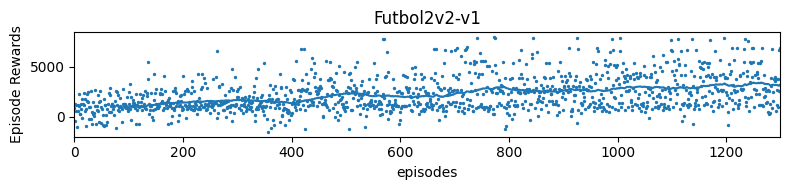

In [12]:
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Futbol2v2-v1")
display.display(plt.gcf())
display.clear_output(wait=True)

## SAC (with optuna hyperparameters)

In [8]:
from stable_baselines3 import SAC
ALGORITHM_NAME="sac-centralized-optuna"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type="box")
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = SAC("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir,
            gamma=0.995,
            learning_rate=0.0017695661826319208,
            batch_size=64,
            buffer_size=100000,
            learning_starts=1000,
            train_freq=4,
            tau=0.005,
            policy_kwargs=dict(log_std_init=0.7756191967711437, net_arch=[400,300]))

In [10]:
model.learn(total_timesteps=timesteps, callback=eval_callback)

Eval num_timesteps=9600, episode_reward=2321.25 +/- 1347.44
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=585.10 +/- 69.54
Episode length: 300.00 +/- 0.00
Eval num_timesteps=28800, episode_reward=1081.80 +/- 1472.03
Episode length: 300.00 +/- 0.00
Eval num_timesteps=38400, episode_reward=1497.97 +/- 1684.56
Episode length: 300.00 +/- 0.00
Eval num_timesteps=48000, episode_reward=1426.73 +/- 1170.72
Episode length: 300.00 +/- 0.00
Eval num_timesteps=57600, episode_reward=1159.87 +/- 161.76
Episode length: 300.00 +/- 0.00
Eval num_timesteps=67200, episode_reward=854.73 +/- 765.85
Episode length: 300.00 +/- 0.00
Eval num_timesteps=76800, episode_reward=2330.68 +/- 1065.57
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=86400, episode_reward=773.02 +/- 620.33
Episode length: 300.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=869.89 +/- 1446.46
Episode length: 300.00 +/- 0.00
Eval num_timesteps=105600, episode_r

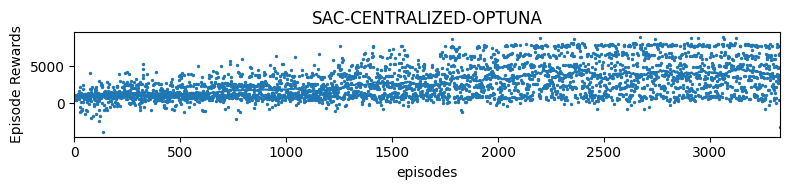

In [11]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## DQN

In [4]:
from stable_baselines3 import DQN
ALGORITHM_NAME="dqn"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"
env = make_vec_env(lambda: gym.make("Futbol2v2-v1", action_space_type="discrete"), n_envs=4, monitor_dir=log_dir)

env_iter = iter(env.envs)
ma_action_env = make_vec_env(
    lambda: utils.TransformAction(next(env_iter), gym.spaces.Discrete(25)),
    n_envs=4
)

models = [
    MultiAgentOffPolicyProxy(DQN("MlpPolicy",
                             ma_action_env,
                             device='cpu', tensorboard_log=tensorboard_log_dir)),
    MultiAgentOffPolicyProxy(DQN("MlpPolicy",
                             ma_action_env,
                             device='cpu', tensorboard_log=tensorboard_log_dir))
]

In [ ]:
multiagent_learn(models, timesteps, env, f"models/footbol/{ALGORITHM_NAME}",
                 action_combiner=lambda acts: np.array(acts).transpose())

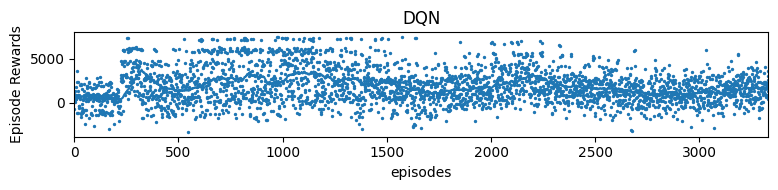

In [6]:
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## DDPG

In [13]:
from stable_baselines3 import DDPG
ALGORITHM_NAME="ddpg"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
env = make_vec_env(lambda: gym.make("Futbol2v2-v1", action_space_type="box"), n_envs=4, monitor_dir=log_dir)

env_iter = iter(env.envs)
ma_action_env = make_vec_env(
    lambda: utils.TransformAction(next(env_iter), gym.spaces.Box(low=-1.0, high=1.0, shape=(1, 4))),
    n_envs=4
)

models = [
    MultiAgentOffPolicyProxy(DDPG("MlpPolicy",
                             ma_action_env,
                             device='cpu', train_freq=(300, "step"))),
    MultiAgentOffPolicyProxy(DDPG("MlpPolicy",
                             ma_action_env,
                             device='cpu', train_freq=(300, "step")))
]

In [ ]:
multiagent_learn(models, timesteps, env, f"models/footbol/{ALGORITHM_NAME}",
                 action_combiner=lambda acts: np.array(acts).transpose())

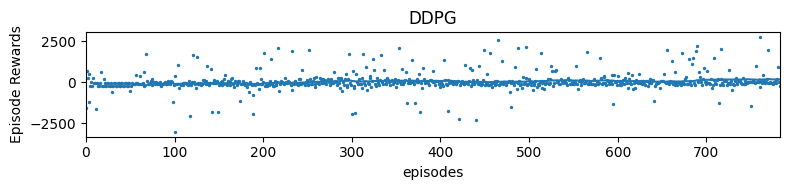

In [15]:
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## TQC

In [3]:
from sb3_contrib import TQC
ALGORITHM_NAME="tqc-centralized"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type=["box", "box"])
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = TQC("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir)

In [4]:
model.learn(total_timesteps=timesteps, callback=eval_callback)

2022-12-18 16:56:56.512436: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-18 16:58:33.476717: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-18 16:58:33.477273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-18 16:58:33.477310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-T

Eval num_timesteps=9600, episode_reward=866.78 +/- 1055.96
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=1216.20 +/- 486.33
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=28800, episode_reward=1410.04 +/- 729.77
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=38400, episode_reward=2771.41 +/- 1351.98
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=48000, episode_reward=1900.55 +/- 1483.14
Episode length: 300.00 +/- 0.00
Eval num_timesteps=57600, episode_reward=2075.20 +/- 816.03
Episode length: 300.00 +/- 0.00
Eval num_timesteps=67200, episode_reward=2499.71 +/- 1034.29
Episode length: 300.00 +/- 0.00
Eval num_timesteps=76800, episode_reward=1597.22 +/- 471.57
Episode length: 300.00 +/- 0.00
Eval num_timesteps=86400, episode_reward=2639.08 +/- 1251.99
Episode length: 300.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=2317.55 +/- 1457.53
Episode length: 300.

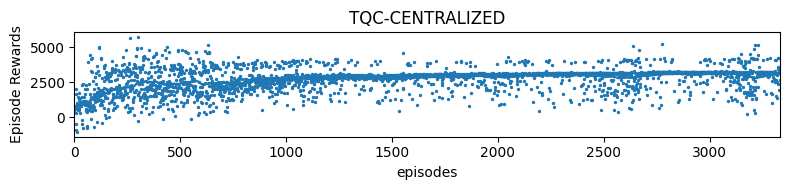

In [5]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## TRPO

In [10]:
from sb3_contrib import TRPO
ALGORITHM_NAME="trpo-centralized"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type="box")
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = TRPO("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir)

In [11]:
model.learn(total_timesteps=timesteps, callback=eval_callback)

Eval num_timesteps=9600, episode_reward=544.20 +/- 184.56
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=579.42 +/- 150.93
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=28800, episode_reward=721.41 +/- 286.15
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=38400, episode_reward=543.68 +/- 1084.35
Episode length: 300.00 +/- 0.00
Eval num_timesteps=48000, episode_reward=1193.79 +/- 1035.85
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=57600, episode_reward=266.27 +/- 633.55
Episode length: 300.00 +/- 0.00
Eval num_timesteps=67200, episode_reward=962.19 +/- 423.82
Episode length: 300.00 +/- 0.00
Eval num_timesteps=76800, episode_reward=523.01 +/- 313.08
Episode length: 300.00 +/- 0.00
Eval num_timesteps=86400, episode_reward=1151.10 +/- 454.35
Episode length: 300.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=873.43 +/- 220.05
Episode length: 300.00 +/- 0.00

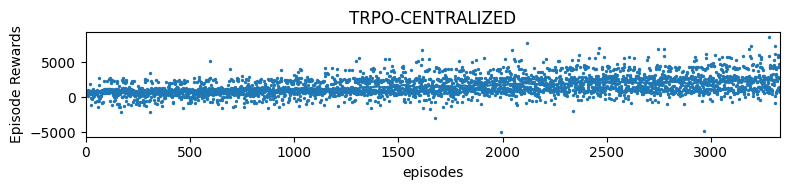

In [12]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## ARS

In [16]:
from sb3_contrib import ARS
ALGORITHM_NAME="ars-centralized"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type="box")
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = ARS("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir)

In [17]:
model.learn(total_timesteps=timesteps, callback=eval_callback)

Eval num_timesteps=9600, episode_reward=-28.92 +/- 57.83
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=-19.32 +/- 24.20
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=28800, episode_reward=-47.22 +/- 88.80
Episode length: 300.00 +/- 0.00
Eval num_timesteps=38400, episode_reward=19.80 +/- 45.26
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=48000, episode_reward=38.32 +/- 69.80
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=57600, episode_reward=139.83 +/- 261.71
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=67200, episode_reward=-26.60 +/- 10.17
Episode length: 300.00 +/- 0.00
Eval num_timesteps=76800, episode_reward=-285.07 +/- 507.21
Episode length: 300.00 +/- 0.00
Eval num_timesteps=86400, episode_reward=-246.96 +/- 425.46
Episode length: 300.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=-101.02 +/- 133.35
Episode length: 30

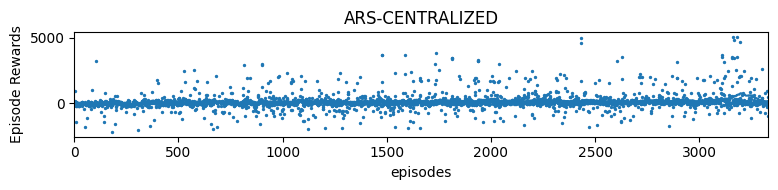

In [7]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## Recurrent PPO (Centralized & Box)

In [3]:
from sb3_contrib import RecurrentPPO
ALGORITHM_NAME="recurrent-ppo-centralized-box"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type="box")
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = RecurrentPPO("MlpLstmPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir)

In [4]:
model.learn(total_timesteps=timesteps, callback=eval_callback)

2022-12-19 10:21:23.321781: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-19 10:21:24.137516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-19 10:21:24.137609: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-19 10:21:24.137620: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-T

Eval num_timesteps=9600, episode_reward=-6.23 +/- 151.63
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=-188.37 +/- 364.47
Episode length: 300.00 +/- 0.00
Eval num_timesteps=28800, episode_reward=575.09 +/- 311.12
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=38400, episode_reward=775.87 +/- 730.66
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=48000, episode_reward=644.51 +/- 199.11
Episode length: 300.00 +/- 0.00
Eval num_timesteps=57600, episode_reward=339.56 +/- 447.80
Episode length: 300.00 +/- 0.00
Eval num_timesteps=67200, episode_reward=1482.80 +/- 724.40
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=76800, episode_reward=469.09 +/- 645.88
Episode length: 300.00 +/- 0.00
Eval num_timesteps=86400, episode_reward=823.21 +/- 157.16
Episode length: 300.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=643.05 +/- 924.38
Episode length: 300.00 +/- 0.00
Ev

KeyboardInterrupt: 

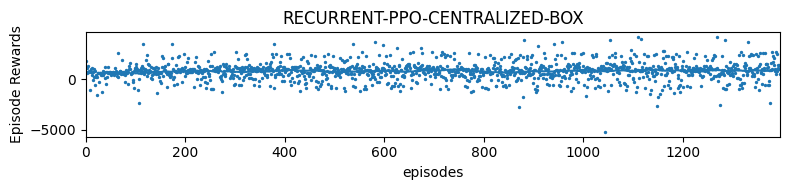

In [5]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

# Learning with hardcoded agent

In [2]:
from agents.simple_attacking_agent import SimpleAttackingAgent
from agents.simple_goalkeeper_agent import SimpleGoalkeeperAgent

timesteps = 1000000

## PPO (Centralized & Multi-Discrete)

In [6]:
ALGORITHM_NAME="ppo-centralized-multi-discrete-hca"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

eval_env = gym.make('Futbol2v2-v1', action_space_type=["multi-discrete", "box"])
eval_env.set_team_b_model(utils.MultiModelAgent([
                   SimpleAttackingAgent(eval_env,  0),
                   SimpleGoalkeeperAgent(eval_env, 1)
               ]))
eval_env = Monitor(eval_env)

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type=["multi-discrete", "box"])
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = PPO("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir)

In [7]:
model.learn(total_timesteps=timesteps, callback=eval_callback)

Eval num_timesteps=9600, episode_reward=-7036.79 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=-5730.51 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=28800, episode_reward=-7527.11 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=38400, episode_reward=-8106.78 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=48000, episode_reward=-7256.82 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=57600, episode_reward=-7438.12 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=67200, episode_reward=-8043.67 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=76800, episode_reward=-7782.76 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=86400, episode_reward=-7854.97 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=-8032.37 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=105600, episode_reward=-6780

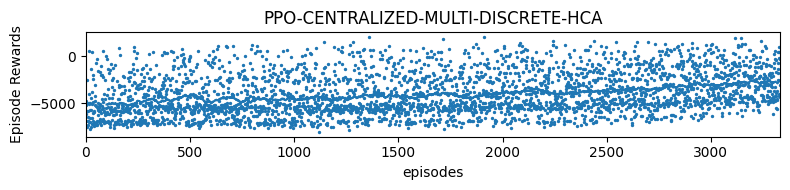

In [8]:
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## PPO (Centralized & Box)

In [14]:
ALGORITHM_NAME="ppo-centralized-box-hca"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

eval_env = gym.make('Futbol2v2-v1', action_space_type=["box", "box"])
eval_env.set_team_b_model(utils.MultiModelAgent([
                   SimpleAttackingAgent(eval_env,  0),
                   SimpleGoalkeeperAgent(eval_env, 1)
               ]))
eval_env = Monitor(eval_env)

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type=["box", "box"])
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = PPO("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir)

In [15]:
model.learn(total_timesteps=timesteps, callback=eval_callback)

Eval num_timesteps=9600, episode_reward=-7185.75 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=-6993.10 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=28800, episode_reward=-7324.87 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=38400, episode_reward=-7583.58 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=48000, episode_reward=-7270.60 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=57600, episode_reward=-6221.40 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=67200, episode_reward=-5271.17 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=76800, episode_reward=-4287.96 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=86400, episode_reward=-6226.76 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=-4753.82 +/- 0.00
Episode lengt

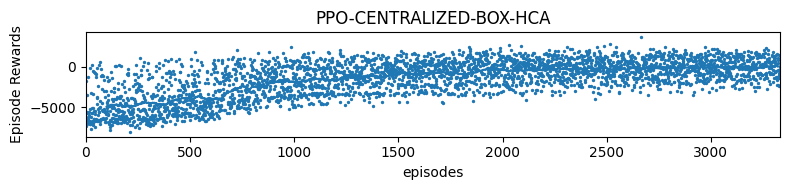

In [16]:
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## SAC (Centralized)

In [13]:
from stable_baselines3 import SAC
ALGORITHM_NAME="sac-centralized-hca"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type=["box", "box"])
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = SAC("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir)

In [14]:
model.learn(total_timesteps=timesteps, callback=eval_callback)

Eval num_timesteps=9600, episode_reward=-8169.48 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=-6508.03 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=28800, episode_reward=-7167.50 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=38400, episode_reward=-5830.78 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=48000, episode_reward=-1596.14 +/- 1065.72
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=57600, episode_reward=-5399.78 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=67200, episode_reward=-523.16 +/- 1276.92
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=76800, episode_reward=-7095.19 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=86400, episode_reward=-6120.79 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=-486.73 +/- 1895.35
Episod

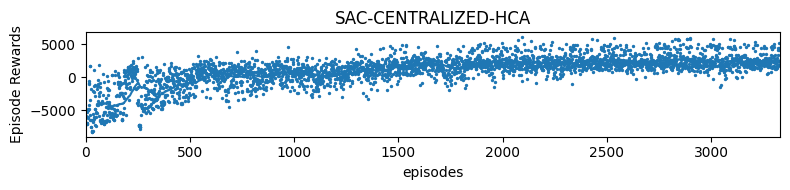

In [16]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## SAC (Centralized & Random start position)
Кажется, что в других экспериментах сеть просто находит неким подобием перебора последовательность действий для конкретно этого агента в конкретно этой ситуации. Для того чтобы улучшить результат, была добавлена возможность рандомизации начальной позиции.

In [3]:
from stable_baselines3 import SAC
ALGORITHM_NAME="sac-centralized-hca-rnd"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1',
                   action_space_type=["box", "box"],
                   random_position=True)
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = SAC("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir)

In [4]:
model.learn(total_timesteps=timesteps, callback=eval_callback)

2022-12-16 09:34:51.605958: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-16 09:34:52.420150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-16 09:34:52.420237: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-16 09:34:52.420249: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-T

Eval num_timesteps=9600, episode_reward=-6046.11 +/- 1083.24
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=-4455.18 +/- 2101.33
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=28800, episode_reward=-1867.26 +/- 1745.81
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=38400, episode_reward=-4109.35 +/- 1070.86
Episode length: 300.00 +/- 0.00
Eval num_timesteps=48000, episode_reward=-3466.71 +/- 1742.15
Episode length: 300.00 +/- 0.00
Eval num_timesteps=57600, episode_reward=-615.44 +/- 1931.76
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=67200, episode_reward=-2812.37 +/- 1589.46
Episode length: 300.00 +/- 0.00
Eval num_timesteps=76800, episode_reward=-1490.89 +/- 1975.98
Episode length: 300.00 +/- 0.00
Eval num_timesteps=86400, episode_reward=-1650.79 +/- 2296.13
Episode length: 300.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=-1887.59 +/- 2906.53
Episod

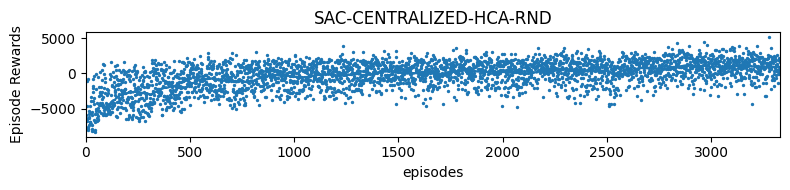

In [5]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

Для корректного сравнения с другими алгоритмами - вычисление среднего значения награды за эпизод в условиях, когда позиция неизменна.

In [9]:
iters_count = 200
total_reward = 0

env = gym.make('Futbol2v2-v1',
               action_space_type=["box", "box"],
               random_position=True)
env.set_team_b_model(utils.MultiModelAgent([
    SimpleAttackingAgent(env,  0),
    SimpleGoalkeeperAgent(env, 1)
]))
model = SAC.load(f'./models/footbol/sac-centralized-hca/last_model', device="cpu")

for i in range(iters_count):
    visualizer = utils.NoVisualizer(env)
    total_reward += visualizer.run(model)

print("Average reward:", total_reward/iters_count)

Average reward: 1824.9856133425667


## SAC (Centralized & Low coefficient)
В предыдущих экспериментах агент мог набрать награду, соизмеримую с голом, за правильное движение по полю. Для уменьшения данного эффекта была добавлена возможность снизить награду за уменьшение расстояния между мячом и воротами и игроками и мячом.

In [3]:
from stable_baselines3 import SAC
ALGORITHM_NAME="sac-centralized-hca-lcf"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1',
                   action_space_type=["box", "box"],
                   team_reward_coeff=1,
                   ball_reward_coeff=1)
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = SAC("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir)

In [4]:
model.learn(total_timesteps=timesteps, callback=eval_callback)

2022-12-16 13:49:10.031190: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-16 13:49:10.814084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-16 13:49:10.814174: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-16 13:49:10.814186: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-T

Eval num_timesteps=9600, episode_reward=-5322.04 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=-5167.47 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=28800, episode_reward=-5024.62 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=38400, episode_reward=-5177.53 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=48000, episode_reward=36.51 +/- 64.35
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=57600, episode_reward=-5129.62 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=67200, episode_reward=-4137.33 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=76800, episode_reward=-5196.15 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=86400, episode_reward=-5202.36 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=-5339.95 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval 

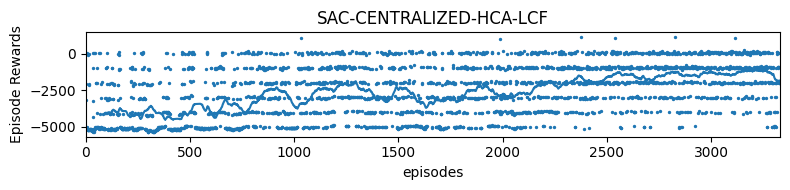

In [5]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## SAC (Centralized & Optuna)

In [9]:
from stable_baselines3 import SAC
ALGORITHM_NAME="sac-centralized-hca-optuna"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1',
                   action_space_type=["box", "box"])
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = SAC("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir,
            gamma=0.99,
            learning_rate=0.0008469028727035853,
            batch_size=512,
            buffer_size=1000000,
            learning_starts=1000,
            train_freq=4,
            tau=0.05,
            policy_kwargs=dict(log_std_init=-1.5552282685320455, net_arch=[256,256]))

In [10]:
model.learn(total_timesteps=timesteps, callback=eval_callback)

Eval num_timesteps=9600, episode_reward=-6481.14 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=-6544.77 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=28800, episode_reward=-7100.00 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=38400, episode_reward=-4276.26 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=48000, episode_reward=-4622.83 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=57600, episode_reward=-7160.33 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=67200, episode_reward=-3205.40 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=76800, episode_reward=188.78 +/- 445.03
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=86400, episode_reward=-634.01 +/- 489.34
Episode length: 300.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=-5244.62 +/- 0.00
Episode length: 300.00 +/- 0.00
Ev

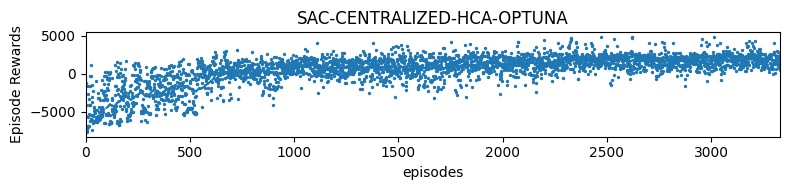

In [11]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## SAC (Concurrent)

In [8]:
from stable_baselines3 import SAC
ALGORITHM_NAME="sac-concurrent-hca"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type=["box", "box"])
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)
env_iter = iter(env.envs)
ma_action_env = make_vec_env(
    lambda: utils.TransformAction(next(env_iter), gym.spaces.Box(low=-1.0, high=1.0, shape=(1, 4))),
    n_envs=4
)

models = [
    MultiAgentOffPolicyProxy(SAC("MlpPolicy",
                                 ma_action_env,
                                 device='cpu',
                                 tensorboard_log=tensorboard_log_dir),
                             log_interval=4,
                             tb_log_name=f'{ALGORITHM_NAME}-0'),
    MultiAgentOffPolicyProxy(SAC("MlpPolicy",
                                 ma_action_env,
                                 device='cpu',
                                 tensorboard_log=tensorboard_log_dir),
                             log_interval=4,
                             tb_log_name=f'{ALGORITHM_NAME}-1')
]

In [9]:
multiagent_learn(models, timesteps, env, f"models/footbol/{ALGORITHM_NAME}")

100%|██████████| 1000000/1000000 [3:57:36<00:00, 70.14it/s] 


Total reward: [ 37061.223 129729.21   51999.074  58105.145]
Average reward: [0.03706122 0.12972921 0.05199907 0.05810514]


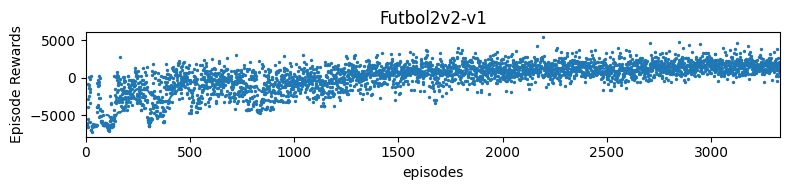

In [10]:
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Futbol2v2-v1")
display.display(plt.gcf())
display.clear_output(wait=True)

## SAC (Concurrent, 128 neurons)
Стандартная архитектура в stable baselines 3 - 2 слоя, по 256 нейрона в каждом. Так как цель данного эксперимента - сравнение конкурентного и централизованного подхода, то при использовании стандартных значений (как в случае выше) у конкурентного подхода отличие в удвоенном размере сети. Это может как увеличивать время обучения (что и наблюдается), так и ухудшать результаты, так как для обучения большей сети нужно больше итераций (что может наблюдаться в предыдущем случае, но не утверждаю, что это так).

In [3]:
from stable_baselines3 import SAC
ALGORITHM_NAME="sac-concurrent-hca-128n"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

policy_kwargs = dict(net_arch=[128, 128])

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type=["box", "box"])
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)
env_iter = iter(env.envs)
ma_action_env = make_vec_env(
    lambda: utils.TransformAction(next(env_iter), gym.spaces.Box(low=-1.0, high=1.0, shape=(1, 4))),
    n_envs=4
)

models = [
    MultiAgentOffPolicyProxy(SAC("MlpPolicy",
                                 ma_action_env,
                                 device='cpu',
                                 tensorboard_log=tensorboard_log_dir,
                                 policy_kwargs=policy_kwargs),
                             log_interval=4,
                             tb_log_name=f'{ALGORITHM_NAME}-0'),
    MultiAgentOffPolicyProxy(SAC("MlpPolicy",
                                 ma_action_env,
                                 device='cpu',
                                 tensorboard_log=tensorboard_log_dir,
                                 policy_kwargs=policy_kwargs),
                             log_interval=4,
                             tb_log_name=f'{ALGORITHM_NAME}-1')
]

In [4]:
multiagent_learn(models, timesteps, env, f"models/footbol/{ALGORITHM_NAME}")

2022-12-15 14:38:24.061597: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-15 14:38:33.862959: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-15 14:38:33.863104: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-15 14:38:33.863119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-T

Total reward: [-779402.7  -763149.56 -748637.5  -839491.2 ]
Average reward: [-0.77940269 -0.76314956 -0.7486375  -0.83949119]


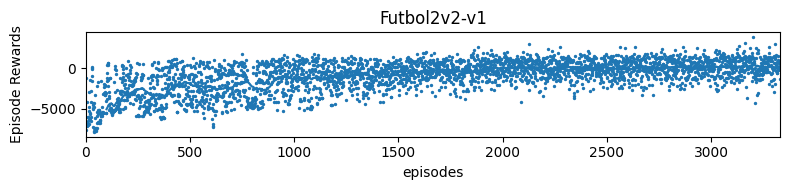

In [5]:
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Futbol2v2-v1")
display.display(plt.gcf())
display.clear_output(wait=True)

## TD3 (Centralized)

In [31]:
from stable_baselines3 import TD3
ALGORITHM_NAME="td3-centralized-hca"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type=["box", "box"])
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = TD3("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir, train_freq=(10, "step"))

In [32]:
model.learn(total_timesteps=timesteps, callback=eval_callback)

Eval num_timesteps=9600, episode_reward=-1270.98 +/- 1157.40
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=-6831.46 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=28800, episode_reward=-3947.38 +/- 594.42
Episode length: 300.00 +/- 0.00
Eval num_timesteps=38400, episode_reward=-6743.22 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=48000, episode_reward=-5120.19 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=57600, episode_reward=-5372.71 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=67200, episode_reward=-5652.09 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=76800, episode_reward=-217.90 +/- 1193.19
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=86400, episode_reward=-291.22 +/- 585.19
Episode length: 300.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=448.01 +/- 535.14
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timestep

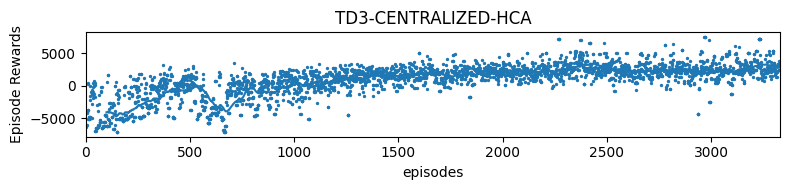

In [33]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## TQC (Centralized)

In [11]:
from sb3_contrib import TQC
ALGORITHM_NAME="tqc-centralized-hca"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type=["box", "box"])
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = TQC("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir)

In [12]:
model.learn(total_timesteps=timesteps, callback=eval_callback)

Eval num_timesteps=9600, episode_reward=-6959.35 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=-5665.26 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=28800, episode_reward=-4717.35 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=38400, episode_reward=-3360.67 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=48000, episode_reward=-6578.12 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=57600, episode_reward=-4886.41 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=67200, episode_reward=923.94 +/- 263.75
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=76800, episode_reward=134.73 +/- 1037.61
Episode length: 300.00 +/- 0.00
Eval num_timesteps=86400, episode_reward=-1263.47 +/- 159.78
Episode length: 300.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=728.26 +/- 809.98
Episode le

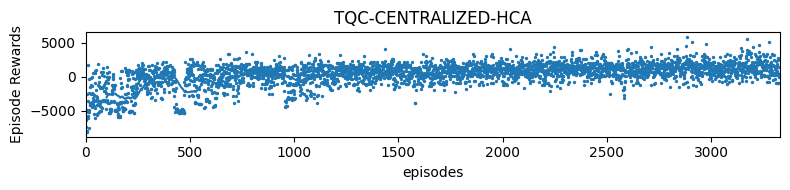

In [13]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## TQC (Concurrent)

In [3]:
from stable_baselines3 import SAC
ALGORITHM_NAME="tqc-concurrent-hca"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
eval_log_dir = f"logs/futbol/eval/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type=["box", "box"])
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)
env_iter = iter(env.envs)
ma_action_env = make_vec_env(
    lambda: utils.TransformAction(next(env_iter), gym.spaces.Box(low=-1.0, high=1.0, shape=(1, 4))),
    n_envs=4
)
eval_env = Monitor(init_football_env())

models = [
    MultiAgentOffPolicyProxy(SAC("MlpPolicy",
                                 ma_action_env,
                                 device='cpu',
                                 tensorboard_log=tensorboard_log_dir),
                             log_interval=4,
                             tb_log_name=f'{ALGORITHM_NAME}-0'),
    MultiAgentOffPolicyProxy(SAC("MlpPolicy",
                                 ma_action_env,
                                 device='cpu',
                                 tensorboard_log=tensorboard_log_dir),
                             log_interval=4,
                             tb_log_name=f'{ALGORITHM_NAME}-1')
]

In [4]:
multiagent_learn(models, timesteps, env, f"models/footbol/{ALGORITHM_NAME}",
                 eval_env=eval_env, eval_log_dir=eval_log_dir, eval_freq=10000)

2022-12-20 20:06:02.851881: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-20 20:06:03.619720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-20 20:06:03.619810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-20 20:06:03.619822: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-T

In [8]:
env.close()

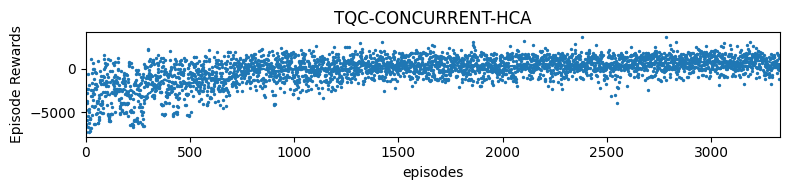

In [6]:
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

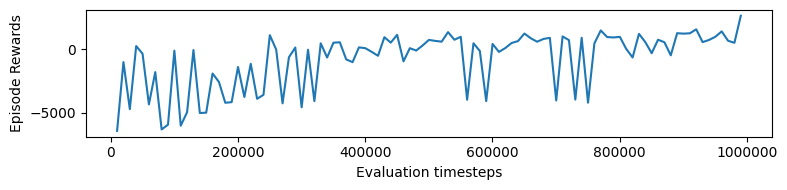

In [7]:
utils.plot_eval_results(eval_log_dir)
display.display(plt.gcf())
display.clear_output(wait=True)

## TRPO (Centralized)

In [16]:
from sb3_contrib import TRPO
ALGORITHM_NAME="trpo-centralized-hca"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type=["box", "box"])
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = TRPO("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir)

In [17]:
model.learn(total_timesteps=timesteps, callback=eval_callback)

Eval num_timesteps=9600, episode_reward=-6994.36 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=-7348.40 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=28800, episode_reward=-7779.86 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=38400, episode_reward=-6466.66 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=48000, episode_reward=-6192.71 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=57600, episode_reward=-6467.32 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=67200, episode_reward=-6670.54 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=76800, episode_reward=-1972.52 +/- 1339.20
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=86400, episode_reward=-5704.90 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=-5499.63 +/- 0.00
Episode length: 300.00 +/- 0.00


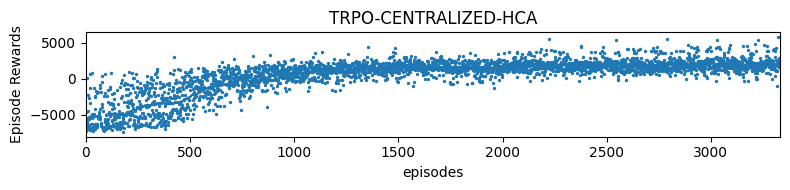

In [18]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## TRPO (Centralized & Optuna coefficients)

In [19]:
from sb3_contrib import TRPO
ALGORITHM_NAME="trpo-centralized-hca-ocf"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env(team_reward, ball_reward):
    env = gym.make('Futbol2v2-v1',
                   action_space_type=["box", "box"],
                   team_reward_coeff=team_reward, ball_reward_coeff=ball_reward)
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env, 0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

eval_env = Monitor(init_football_env(10, 10))
env = make_vec_env(lambda: init_football_env(8, 0), n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = TRPO("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir)

In [20]:
model.learn(total_timesteps=timesteps, callback=eval_callback)

Eval num_timesteps=9600, episode_reward=-7706.75 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=-6856.74 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=28800, episode_reward=-6338.13 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=38400, episode_reward=-6426.37 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=48000, episode_reward=-5574.07 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=57600, episode_reward=-4802.17 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=67200, episode_reward=-4677.94 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=76800, episode_reward=-2048.93 +/- 31.03
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=86400, episode_reward=96.64 +/- 1115.80
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval 

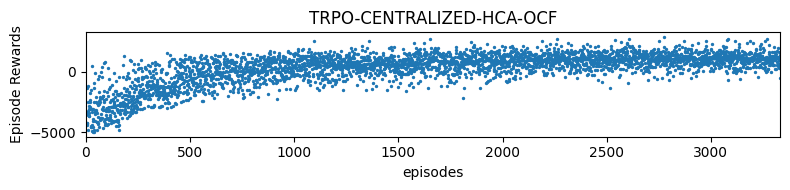

In [21]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## TRPO (Centralized & Optuna)

In [4]:
from torch import nn as nn
from sb3_contrib import TRPO
ALGORITHM_NAME="trpo-centralized-hca-optuna"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type=["box", "box"])
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = TRPO("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir,
             batch_size=8, n_steps=1024, gamma=0.99, learning_rate=0.001519948252579201, n_critic_updates=10,
             cg_max_steps=30, target_kl=0.1, gae_lambda=0.99,
             policy_kwargs=dict(
                 net_arch=[dict(pi=[256, 256], vf=[256, 256])],
                 activation_fn=nn.ReLU,
                 ortho_init=False
             ))

In [5]:
model.learn(total_timesteps=timesteps, callback=eval_callback)

2022-12-20 09:40:53.984910: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-20 09:41:04.413962: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-20 09:41:04.414123: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-20 09:41:04.414137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-T

Eval num_timesteps=9600, episode_reward=-6798.04 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=-6400.61 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=28800, episode_reward=-7173.41 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=38400, episode_reward=-6217.05 +/- 451.91
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=48000, episode_reward=-6776.74 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=57600, episode_reward=-3987.25 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=67200, episode_reward=-4012.79 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=76800, episode_reward=-4077.08 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=86400, episode_reward=-1220.34 +/- 482.38
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=96000, episode_reward=-988.13 +/- 0.00
Episode le

KeyboardInterrupt: 

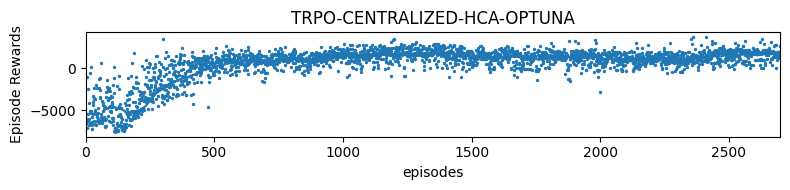

In [6]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## TRPO (Concurrent)

In [3]:
from sb3_contrib import TRPO
ALGORITHM_NAME="trpo-concurrent-hca"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type=["box", "box"])
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)
env_iter = iter(env.envs)
ma_action_env = make_vec_env(
    lambda: utils.TransformAction(next(env_iter), gym.spaces.Box(low=-1.0, high=1.0, shape=(1, 4))),
    n_envs=4
)

models = [
    MultiAgentOnPolicyProxy(TRPO("MlpPolicy",
                                 ma_action_env,
                                 device='cpu',
                                 tensorboard_log=tensorboard_log_dir),
                             tb_log_name=f'{ALGORITHM_NAME}-0'),
    MultiAgentOnPolicyProxy(TRPO("MlpPolicy",
                                 ma_action_env,
                                 device='cpu',
                                 tensorboard_log=tensorboard_log_dir),
                             tb_log_name=f'{ALGORITHM_NAME}-1')
]

In [4]:
multiagent_learn(models, timesteps, env, f"models/footbol/{ALGORITHM_NAME}")

/tmp/ipykernel_10485/1175732888.py:1: DeprecationWarning: Parameters `eval_env` and `eval_freq` are deprecated and will be removed in the future. Please use `EvalCallback` or a custom Callback instead.
  multiagent_learn(models, timesteps, env, f"models/footbol/{ALGORITHM_NAME}")
2022-12-20 12:27:46.804339: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-20 12:27:47.577974: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-20 12:27:47.578066: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_

Total reward: [587097.44 572956.8  588449.3  524944.6 ]
Average reward: [0.58709744 0.57295681 0.58844931 0.52494463]


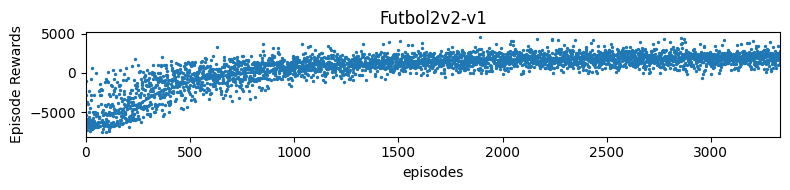

In [5]:
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, "Futbol2v2-v1")
display.display(plt.gcf())
display.clear_output(wait=True)

# Learning with self-play

In [6]:
from agents.simple_attacking_agent import SimpleAttackingAgent
from agents.simple_goalkeeper_agent import SimpleGoalkeeperAgent

timesteps = 1000000
change_to_me_count = 50

## SAC (Centralized)

In [3]:
from stable_baselines3 import SAC
ALGORITHM_NAME="sac-centralized-self-playing"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type=["box", "box"])
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = SAC("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir)

In [4]:
learn_iter_timesteps = timesteps//change_to_me_count
for change_count in range(change_to_me_count):
    model.learn(total_timesteps=learn_iter_timesteps, callback=eval_callback, reset_num_timesteps=False)

    save_path = f"self-play-tmp/{ALGORITHM_NAME}-{change_count}"
    model.save(save_path)
    model_copy = model.load(save_path, device="cpu")

    env.env_method("set_team_b_model", model_copy)

2022-12-17 16:58:52.016011: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-17 16:58:52.878314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-17 16:58:52.878416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-17 16:58:52.878428: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-T

Eval num_timesteps=9600, episode_reward=-4779.32 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=-7076.62 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=28800, episode_reward=-4949.77 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=38400, episode_reward=-5097.20 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=48000, episode_reward=-5279.62 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=57600, episode_reward=-6776.34 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=67200, episode_reward=-4978.42 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=76800, episode_reward=-5142.10 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=86400, episode_reward=-4009.87 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=96000, episode_reward=-3767.02 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!


/home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:276: UserWarning: Path 'self-play-tmp' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Eval num_timesteps=105600, episode_reward=-262.55 +/- 384.76
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=115200, episode_reward=-4845.27 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=124800, episode_reward=-4932.46 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=134400, episode_reward=-4729.39 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=144000, episode_reward=96.06 +/- 1044.27
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=153600, episode_reward=-327.69 +/- 1855.85
Episode length: 300.00 +/- 0.00
Eval num_timesteps=163200, episode_reward=-5466.20 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=172800, episode_reward=-5829.53 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=182400, episode_reward=-5672.43 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=192000, episode_reward=-5699.42 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=201600, episod

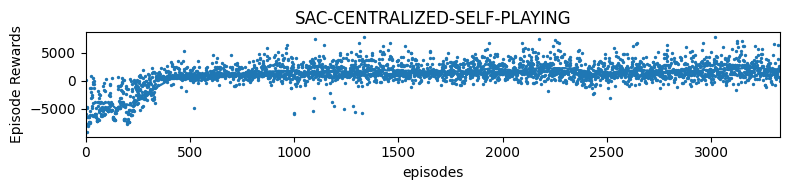

In [5]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## SAC (Centralized & HCA-based)

In [3]:
from stable_baselines3 import SAC
ALGORITHM_NAME="sac-centralized-hca-self-playing"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type=["box", "box"])
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = SAC.load(f"models/footbol/sac-centralized-hca/last_model",
                 env, device="cpu", tensorboard_log=tensorboard_log_dir)

In [4]:
learn_iter_timesteps = timesteps//change_to_me_count
for change_count in range(change_to_me_count):
    model.learn(total_timesteps=learn_iter_timesteps, callback=eval_callback, reset_num_timesteps=False)

    save_path = f"self-play-tmp/{ALGORITHM_NAME}-{change_count}"
    model.save(save_path)
    model_copy = model.load(save_path, device="cpu")

    env.env_method("set_team_b_model", model_copy)

2022-12-18 13:00:44.551181: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-18 13:00:59.368493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-18 13:00:59.368894: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shenk/ДЗ/ВКРv2/hai-nonconflict-action-learning/venv/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-18 13:00:59.368928: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-T

Eval num_timesteps=1009600, episode_reward=2497.65 +/- 586.44
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1019200, episode_reward=1445.52 +/- 495.30
Episode length: 300.00 +/- 0.00
Eval num_timesteps=1028800, episode_reward=-4377.24 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=1038400, episode_reward=-4313.26 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=1048000, episode_reward=-4317.27 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=1057600, episode_reward=-5046.53 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=1067200, episode_reward=-4604.50 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=1076800, episode_reward=-4395.88 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=1086400, episode_reward=-4505.77 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=1096000, episode_reward=-4747.49 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=1105600, episode_reward=279

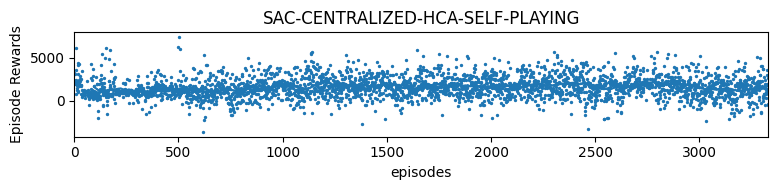

In [5]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## TRPO (Centralized)

In [7]:
from sb3_contrib import TRPO
ALGORITHM_NAME="trpo-centralized-self-playing"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type=["box", "box"])
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env, best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/', eval_freq=2400, render=False)

model = TRPO("MlpPolicy", env, device="cpu", tensorboard_log=tensorboard_log_dir)

In [8]:
learn_iter_timesteps = timesteps//change_to_me_count
for change_count in range(change_to_me_count):
    model.learn(total_timesteps=learn_iter_timesteps, callback=eval_callback, reset_num_timesteps=False)

    save_path = f"self-play-tmp/{ALGORITHM_NAME}-{change_count}"
    model.save(save_path)
    model_copy = model.load(save_path, device="cpu")

    env.env_method("set_team_b_model", model_copy)

Eval num_timesteps=9600, episode_reward=-7220.63 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=19200, episode_reward=-6059.65 +/- 0.00
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=28800, episode_reward=-6543.00 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=38400, episode_reward=-6572.58 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=48000, episode_reward=-470.50 +/- 436.58
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=57600, episode_reward=-8802.27 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=67200, episode_reward=-6129.50 +/- 71.61
Episode length: 300.00 +/- 0.00
Eval num_timesteps=76800, episode_reward=-8697.44 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=86400, episode_reward=-936.19 +/- 1194.68
Episode length: 300.00 +/- 0.00
Eval num_timesteps=96000, episode_reward=-8463.60 +/- 0.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=10

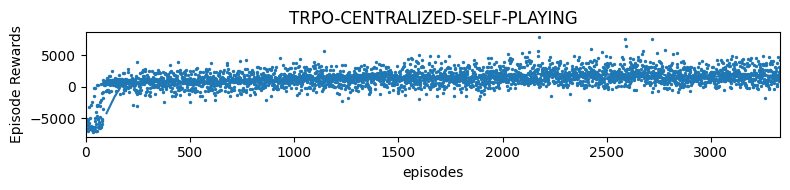

In [9]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

## TRPO (Centralized & HCA-based)

In [2]:
from sb3_contrib import TRPO
ALGORITHM_NAME="trpo-centralized-hca-self-playing"

log_dir = f"logs/futbol/{ALGORITHM_NAME}"
eval_log_dir = f"logs/futbol/eval/{ALGORITHM_NAME}"
tensorboard_log_dir = f"tensorboard/log/{ALGORITHM_NAME}"

def init_football_env():
    env = gym.make('Futbol2v2-v1', action_space_type=["box", "box"])
    env.set_team_b_model(utils.MultiModelAgent([
        SimpleAttackingAgent(env,  0),
        SimpleGoalkeeperAgent(env, 1)
    ]))
    return env

eval_env = Monitor(init_football_env())
env = make_vec_env(init_football_env, n_envs=4, monitor_dir=log_dir)

eval_callback = EvalCallback(eval_env,
                             best_model_save_path=f'./models/footbol/{ALGORITHM_NAME}/',
                             eval_freq=2400,
                             log_path=eval_log_dir,
                             n_eval_episodes=10)

model = TRPO.load(f"models/footbol/trpo-centralized-hca/last_model",
                 env, device="cpu", tensorboard_log=tensorboard_log_dir)

NameError: name 'SimpleAttackingAgent' is not defined

In [11]:
learn_iter_timesteps = timesteps//change_to_me_count
for change_count in range(change_to_me_count):
    model.learn(total_timesteps=learn_iter_timesteps, callback=eval_callback, reset_num_timesteps=False)

    save_path = f"self-play-tmp/{ALGORITHM_NAME}-{change_count}"
    model.save(save_path)
    model_copy = model.load(save_path, device="cpu")

    env.env_method("set_team_b_model", model_copy)

Eval num_timesteps=1017216, episode_reward=2478.88 +/- 372.11
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1026816, episode_reward=2646.94 +/- 211.96
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1036416, episode_reward=2811.35 +/- 708.89
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1046016, episode_reward=2209.01 +/- 226.28
Episode length: 300.00 +/- 0.00
Eval num_timesteps=1055616, episode_reward=2040.25 +/- 660.00
Episode length: 300.00 +/- 0.00
Eval num_timesteps=1065216, episode_reward=2273.31 +/- 89.66
Episode length: 300.00 +/- 0.00
Eval num_timesteps=1074816, episode_reward=2973.10 +/- 930.93
Episode length: 300.00 +/- 0.00
New best mean reward!
Eval num_timesteps=1084416, episode_reward=1807.44 +/- 717.11
Episode length: 300.00 +/- 0.00
Eval num_timesteps=1094016, episode_reward=2022.03 +/- 321.09
Episode length: 300.00 +/- 0.00
Eval num_timesteps=1103616, episode_reward=2243.45 +/- 284.62
Episo

In [12]:
model.save(f'./models/footbol/{ALGORITHM_NAME}/last_model')
env.close()

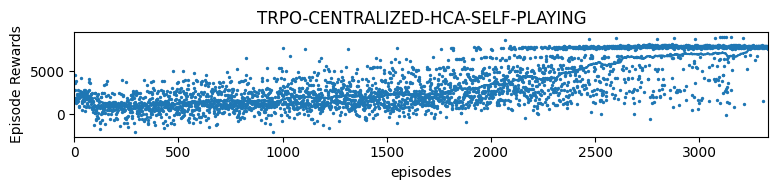

In [13]:
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_EPISODES, ALGORITHM_NAME.upper())
display.display(plt.gcf())
display.clear_output(wait=True)

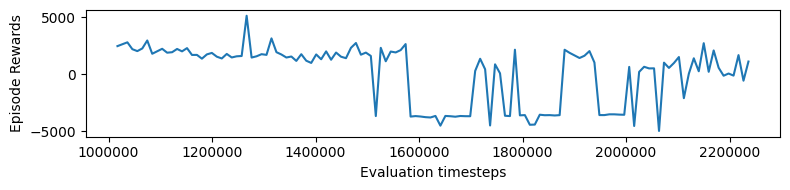

In [3]:
utils.plot_eval_results(eval_log_dir)
display.display(plt.gcf())
display.clear_output(wait=True)